In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! mkdir /root/.kaggle
! cp '/content/drive/My Drive/Un/kaggle.json' /root/.kaggle
# ! cp '/content/kaggle.json' /root/.kaggle
! chmod 400 /root/.kaggle/kaggle.json

!pip uninstall -y kaggle >> quit
!pip install --upgrade pip >> quit
!pip install kaggle==1.5.6 >> quit
!kaggle -v >> quit

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.7.0 requires urllib3>=1.25, but you have urllib3 1.24.3 which is incompatible.


In [3]:
!kaggle datasets download -d hijest/genre-classification-dataset-imdb

 89% 37.0M/41.7M [00:01<00:00, 28.5MB/s]
100% 41.7M/41.7M [00:01<00:00, 23.4MB/s]


In [4]:
!unzip /content/genre-classification-dataset-imdb.zip

Archive:  /content/genre-classification-dataset-imdb.zip
  inflating: Genre Classification Dataset/description.txt  
  inflating: Genre Classification Dataset/test_data.txt  
  inflating: Genre Classification Dataset/test_data_solution.txt  
  inflating: Genre Classification Dataset/train_data.txt  


In [5]:
import os, re
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data Loading

In [7]:
train_df = pd.read_csv("/content/Genre Classification Dataset/train_data.txt", sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
test_df = pd.read_csv("/content/Genre Classification Dataset/test_data_solution.txt", sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

In [8]:
train_df.shape, test_df.shape

((54214, 3), (54200, 3))

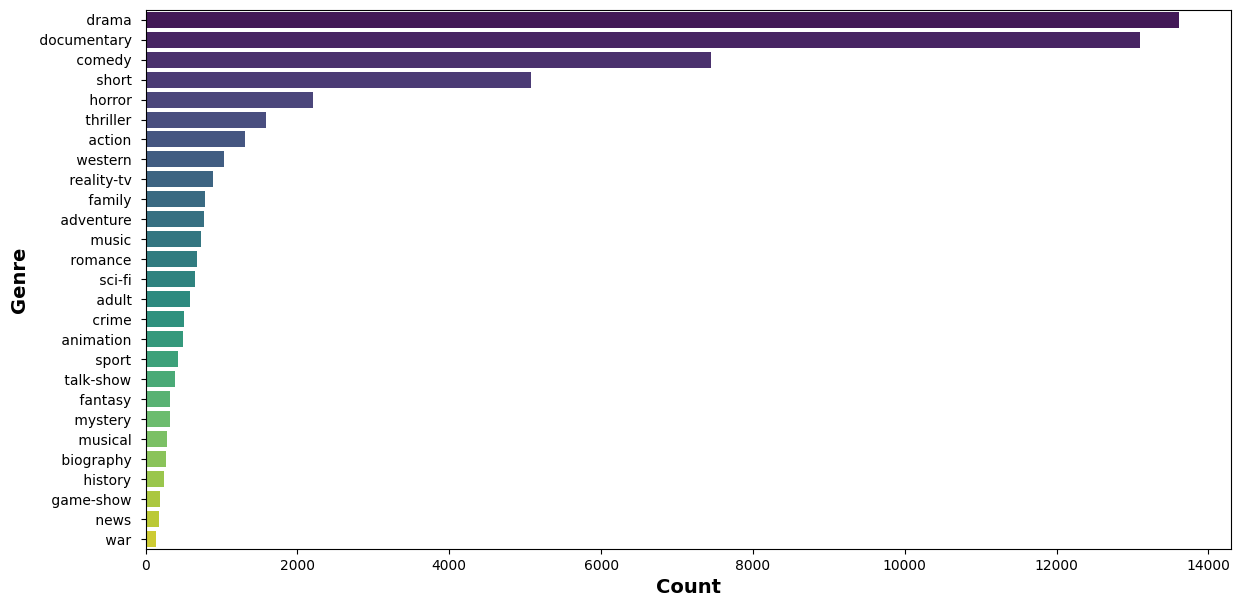

In [9]:
# Plot the distribution of genres in the training data
plt.figure(figsize=(14, 7))
sns.countplot(data=train_df, y='Genre', order=train_df['Genre'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')
plt.show()

## Data Processing

In [10]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

In [11]:
train_df['Text_cleaning'] = train_df['Description'].apply(clean_text)
test_df['Text_cleaning'] = test_df['Description'].apply(clean_text)

## TF-IDF Model

In [12]:
tfidf_vec = TfidfVectorizer()

X_train = tfidf_vec.fit_transform(train_df['Text_cleaning'])
X_test = tfidf_vec.transform(test_df['Text_cleaning'])

In [13]:
X_train.shape, X_test.shape

((54214, 124210), (54200, 124210))

In [14]:
X = X_train
y = train_df['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.44526422576777647
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.61      0.04      0.07      1443
       crime        0.00      0.00      0.00       107
 documentary        0.54      0.90      0.67      2659
       drama        0.38      0.88      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
tfidf_vec = TfidfVectorizer(ngram_range=(1, 2))

X_train = tfidf_vec.fit_transform(train_df['Text_cleaning'])
X_test = tfidf_vec.transform(test_df['Text_cleaning'])

In [16]:
X_train.shape, X_test.shape

((54214, 2212765), (54200, 2212765))

In [17]:
X = X_train
y = train_df['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.44397307018352855
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.68      0.01      0.02      1443
       crime        0.00      0.00      0.00       107
 documentary        0.55      0.90      0.68      2659
       drama        0.37      0.90      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# https://colab.research.google.com/github/scoutbee/pytorch-nlp-notebooks/blob/master/3_rnn_text_classification.ipynb

## LSTM

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import time
import torch as t
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
train_df['Text_cleaning'].apply(lambda x: x.split(" ").__len__()).describe()

count    54214.000000
mean        56.763659
std         42.027418
min          4.000000
25%         31.000000
50%         44.000000
75%         68.000000
max       1092.000000
Name: Text_cleaning, dtype: float64

In [20]:
max_length = 100
max_features = 120000

In [21]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_df['Text_cleaning']))
X_train = tokenizer.texts_to_sequences(train_df['Text_cleaning'])
X_test = tokenizer.texts_to_sequences(test_df['Text_cleaning'])

## Pad the sentences
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

In [22]:
X_train.shape, X_test.shape

((54214, 100), (54200, 100))

In [23]:
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
y_train = lencoder.fit_transform(train_df['Genre'].values)
y_test = lencoder.transform(test_df['Genre'].values)

In [24]:
class BiLSTM(nn.Module):

    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(lencoder.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [25]:
embed_size = 300
batch_size = 512
embedding_matrix = np.random.randn(120000,300)

In [28]:
n_epochs = 6
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(X_train, dtype=torch.long).cuda()
y_train = torch.tensor(y_train, dtype=torch.long).cuda()
x_cv = torch.tensor(X_test, dtype=torch.long).cuda()
y_cv = torch.tensor(y_test, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

    # Set model to validation configuration -Doesn't get trained here
    model.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(lencoder.classes_)))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()

    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==y_test)/len(y_test)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-28-9c8fb4820a4f>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).cuda()
<ipython-input-28-9c8fb4820a4f>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=1237.6315 	 val_loss=1132.5879  	 val_acc=0.4082  	 time=2.25s
Epoch 2/6 	 loss=1055.9951 	 val_loss=1001.8455  	 val_acc=0.4425  	 time=2.29s
Epoch 3/6 	 loss=961.4531 	 val_loss=954.8944  	 val_acc=0.4637  	 time=2.72s
Epoch 4/6 	 loss=892.0831 	 val_loss=935.5187  	 val_acc=0.4661  	 time=2.37s
Epoch 5/6 	 loss=830.8560 	 val_loss=937.7201  	 val_acc=0.4679  	 time=1.94s
Epoch 6/6 	 loss=775.1383 	 val_loss=947.0367  	 val_acc=0.4736  	 time=2.23s


## BERT

In [29]:
import random
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler





In [30]:
possible_labels = train_df.Genre.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{' drama ': 0,
 ' thriller ': 1,
 ' adult ': 2,
 ' documentary ': 3,
 ' comedy ': 4,
 ' crime ': 5,
 ' reality-tv ': 6,
 ' horror ': 7,
 ' sport ': 8,
 ' animation ': 9,
 ' action ': 10,
 ' fantasy ': 11,
 ' short ': 12,
 ' sci-fi ': 13,
 ' music ': 14,
 ' adventure ': 15,
 ' talk-show ': 16,
 ' western ': 17,
 ' family ': 18,
 ' mystery ': 19,
 ' history ': 20,
 ' news ': 21,
 ' biography ': 22,
 ' romance ': 23,
 ' game-show ': 24,
 ' musical ': 25,
 ' war ': 26}

In [31]:
train_df['label'] = train_df.Genre.replace(label_dict)
test_df['label'] = test_df.Genre.replace(label_dict)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(train_df.index.values,
                                                  train_df.label.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=train_df.label.values)

In [34]:
train_df['data_type'] = ['not_set']*train_df.shape[0]

train_df.loc[X_train, 'data_type'] = 'train'
train_df.loc[X_val, 'data_type'] = 'val'

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [37]:
train_df.head()

,Title,Genre,Description,Text_cleaning,label,data_type
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...,0,train
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,1,val
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...,2,train
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...,0,val
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers recovered bodies ground zer...,0,train


In [38]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df[train_df.data_type=='train'].Description.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=100,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    train_df[train_df.data_type=='val'].Description.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=100,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df[train_df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(train_df[train_df.data_type=='val'].label.values)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [39]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [40]:
len(dataset_train), len(dataset_val)

(46081, 8133)

In [41]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:

batch_size = 5

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [43]:

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [50]:
epochs = 2

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [51]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [52]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [54]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [55]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/9217 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0187077111517793
Validation loss: 1.1973582891027255
F1 Score (Weighted): 0.6377882173576145


Epoch 2:   0%|          | 0/9217 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7398176352372515
Validation loss: 1.3416551705747477
F1 Score (Weighted): 0.6412213973616456


In [56]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [57]:
accuracy_per_class(predictions, true_vals)

Class:  drama 
Accuracy: 1542/2042

Class:  thriller 
Accuracy: 86/239

Class:  adult 
Accuracy: 48/88

Class:  documentary 
Accuracy: 1714/1965

Class:  comedy 
Accuracy: 702/1117

Class:  crime 
Accuracy: 10/76

Class:  reality-tv 
Accuracy: 58/133

Class:  horror 
Accuracy: 245/331

Class:  sport 
Accuracy: 42/65

Class:  animation 
Accuracy: 18/75

Class:  action 
Accuracy: 92/197

Class:  fantasy 
Accuracy: 13/48

Class:  short 
Accuracy: 361/761

Class:  sci-fi 
Accuracy: 57/97

Class:  music 
Accuracy: 78/110

Class:  adventure 
Accuracy: 31/116

Class:  talk-show 
Accuracy: 28/59

Class:  western 
Accuracy: 138/155

Class:  family 
Accuracy: 32/117

Class:  mystery 
Accuracy: 2/48

Class:  history 
Accuracy: 1/36

Class:  news 
Accuracy: 5/27

Class:  biography 
Accuracy: 0/40

Class:  romance 
Accuracy: 9/101

Class:  game-show 
Accuracy: 22/29

Class:  musical 
Accuracy: 7/41

Class:  war 
Accuracy: 6/20



In [59]:
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()

In [60]:
from sklearn import metrics

In [61]:
metrics.accuracy_score(labels_flat,preds_flat)

0.6574449772531661